<a href="https://colab.research.google.com/github/HwangHanJae/ml-definitive-guide-pratice/blob/main/classification/stacking_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 스태킹(Stacking)
### : 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행하는 방식
- 캐글과 같은 대회에서 높은 순위를 차지하기 위해 조금이라도 성능 수치를 올려야할 경우 자주 사용
- 스태킹을 적용할 때는 많은 개별 모델이 필요함
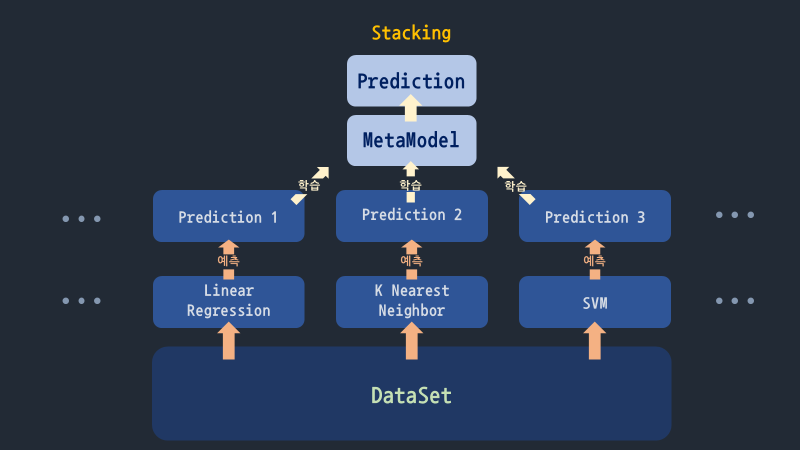

개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어   
별도의 ML 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식
- 이때 개별 모델의 예측된 데이터 세트를 다시 기반으로 하여 학습하고 예측하는 방식을 메타 모델이라고 함



## 스태킹알고리즘 Step
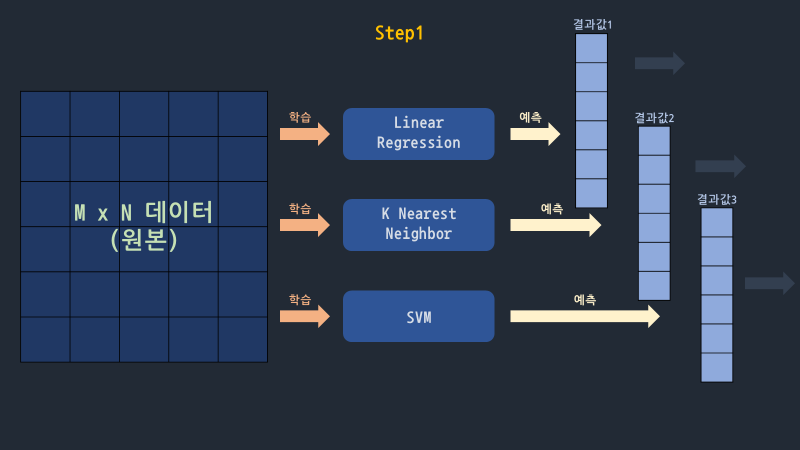

1. M 개의 로우, N개의 피처(칼럼)을 가진 데이터 세트가 존재
2. 3개의 머신러닝 알고리즘 모델을 학습시킨뒤 예측을 수행
3. 각각 M개의 로우를 가진 1개의 레이블 값을 도출

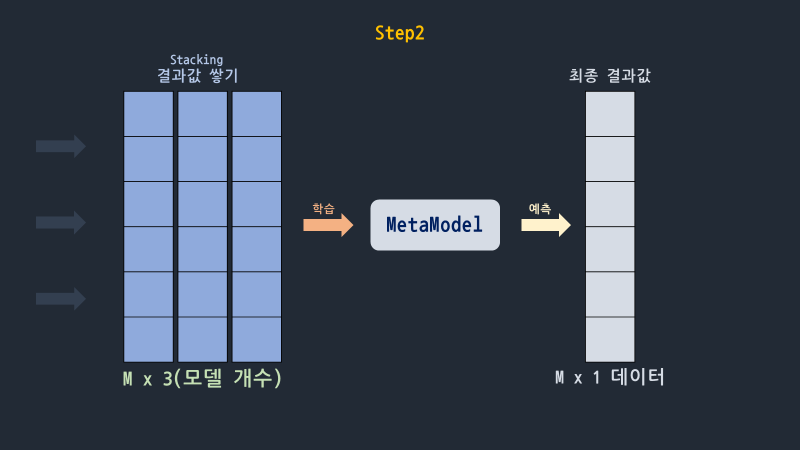

1. 모델별로 도출된 예측 데이터 값을 다시 합침(Stacking)
2. 새로운 데이터에 대하여 모델을 학습
3. 최종 예측

### 기본 스태킹(Stacking) 모델
- 위스콘신 암 데이터 세트에 적용

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [ ]:
#개별 모델 생성
knn = KNeighborsClassifier(n_neighbors=4)
rf = RandomForestClassifier(random_state=0)
dt = DecisionTreeClassifier()
ada = AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

In [ ]:
models =  [knn, rf, dt, ada]
results = []
for model in models:
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  print(f"{model.__class__.__name__} 정확도 : {round(accuracy_score(y_test, pred),4)}")
  results.append(pred)


KNeighborsClassifier 정확도 : 0.9211
RandomForestClassifier 정확도 : 0.9649
DecisionTreeClassifier 정확도 : 0.9123
AdaBoostClassifier 정확도 : 0.9561


In [ ]:
#개별 모델로 만든 예측 데이터를 이용하여 메타 모델 만들고 학습
predict = np.array(results)
print(predict.shape)

#transpose를 이용하여 행과 열의 위치 교환
pred = np.transpose(predict)
print(pred.shape)

(4, 114)
(114, 4)


In [ ]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print("최종 메타 모델의 예측 정확도 : {}".format(round(accuracy_score(y_test, final),4)))

최종 메타 모델의 예측 정확도 : 0.9737


개별 모델의 예측 데이터를 스태킹으로 재구성해 메타 모델에서 학습하고 예측한 결과  
정확도가 97.37%로 개별 모델의 정확도보다 향상되었음  
**하지만 스태킹 기법이 무조건 성능이 좋아진다는 보장은없음**

**최종 학습할때 레이블 데이터 세트로 학습 데이터가 아닌**  
**테스트용 레이블 데이터 세트를 기반으로 학습 했기에 과적합 문제가 발생할 수 있음**

## CV 세트 기반의 스태킹
- 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용
- 개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용 스태킹 데이터 생성과 예측을 위한 테스트용 스태킹 데이터를 생성한 뒤 이를 기반으로 메타 모델이 학습과 예측을 수행

### CV 세트 기반의 스태킹 Step


####Step1
각 모델 별로 원본/학습 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성
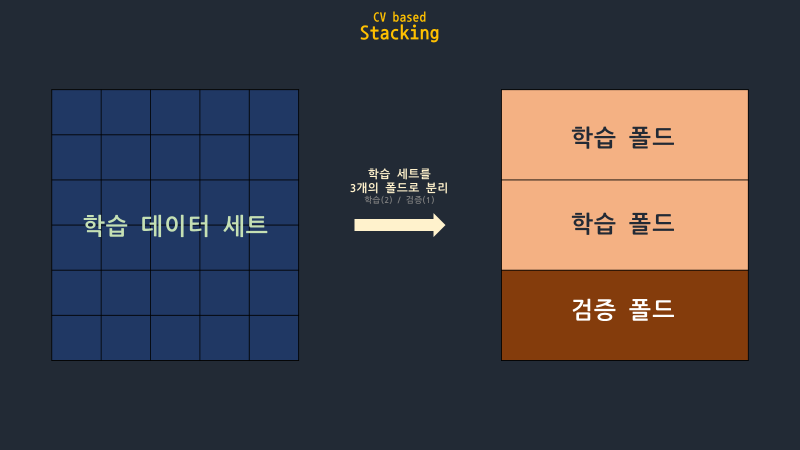

교차검증을 위하여 폴드 개수 만큼의 폴드로 분리함  
(예제에서는 3개의 학습 2개, 검증 1개 폴드로 분리함

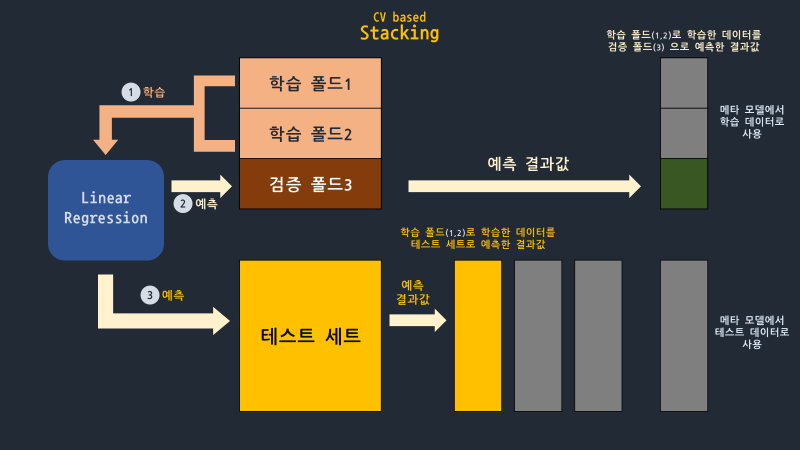

3개의 폴드로 나눈 데이터중 2개는 학습을 진행  
나머지 1개의 데이터로 2개의 학습을 진행한 데이터로 예측을 하여 결과값을 생성함  
**이때 생성된 예측 결과값은 메타 모델에서 학습데이터로 사용을 할것임**  
다음 2개의 학습 데이터로 만든 개별 모델로 테스트 세트의 예측을 진행  
테스트 세트로 예측한 결과값을 생성

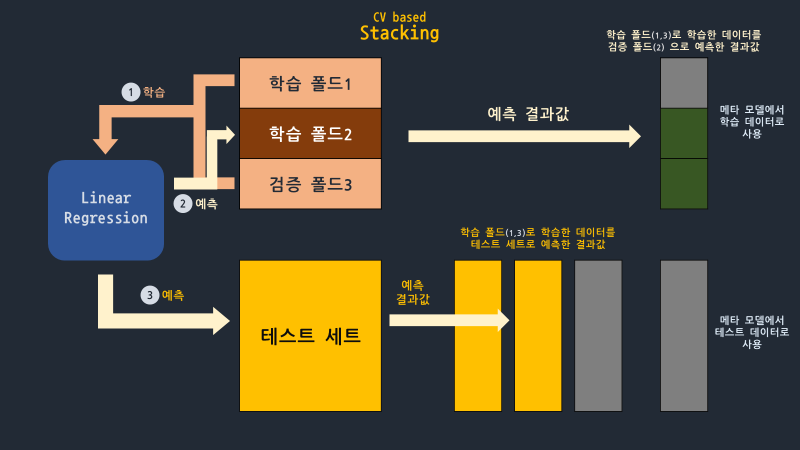

위의 과정과 마찬가지로 두번째 반복을 진행함
두번째 과정에서는 첫번째 과정과 다르게 학습폴드와 검증폴드를 다르게 적용함

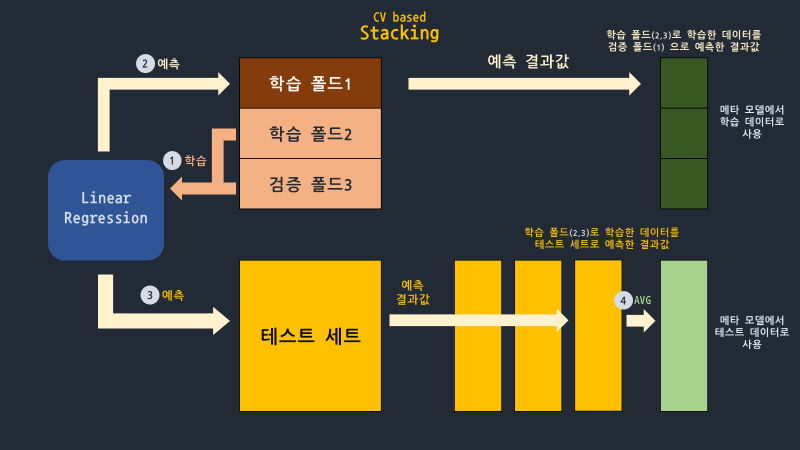

마지막 세번째 반복에서는 위의 두번째 반복에서 처럼 학습폴드와 검증폴드를 다르게 하여 진행함  
다음으로 첫번째, 두번째, 세번째 반복을 수행하면서 만들어진 폴드별 예측 데이터를 합하여  
**메타 모델에서 사용될 학습 테이터를 만듬**  
마찬가지로 개별 모델이 원본 테스트 데이터로 예측한 결과를 최종 평균 하여  
**메타 모델에서 사용될 테스트 데이터를 만듬**

#### Step2

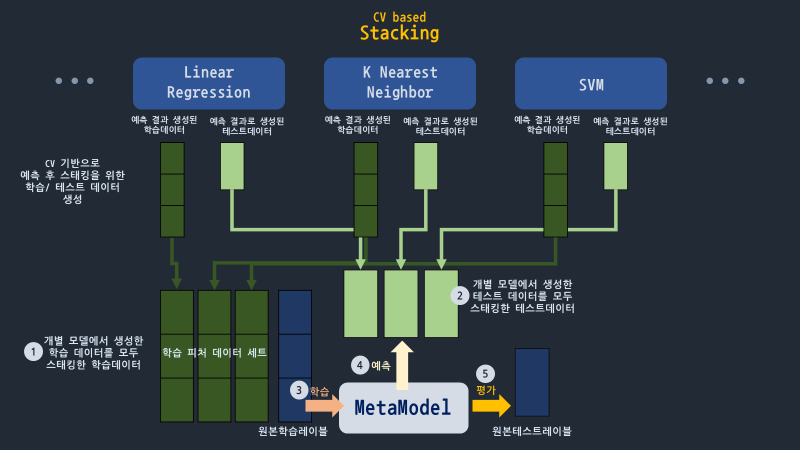

1. Step1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성
2. 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 테스트 데이터 세트를 생성
3. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습
4. 최종적으로 생성된 테스트 데이터 세트를 예측
5. 원본 테스트 데이터의 레이블 데이터를 기반으로 평가


### CV 세트 기반 스태킹 모델

#### Step1 구현

In [34]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train, y_train, X_test,n_folds):
  # 지정된 n_folds 값으로 KFold 생성
  kf = KFold(n_splits=n_folds, shuffle= False)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train.shape[0],1))
  test_pred = np.zeros((X_test.shape[0], n_folds))

  print(model.__class__.__name__, "시작")

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print("\t 폴드 세트 :", folder_counter)
    X_tr =X_train[train_index]
    y_tr = y_train[train_index]
    X_te = X_train[valid_index]

    #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
    model.fit(X_tr, y_tr)
    #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
    test_pred[:, folder_counter] = model.predict(X_test)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

  #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean



In [35]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

knn = KNeighborsClassifier(n_neighbors=4)
rf = RandomForestClassifier(random_state=0)
dt = DecisionTreeClassifier()
ada = AdaBoostClassifier(n_estimators=100)



knn_train, knn_test = get_stacking_base_datasets(knn, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada, X_train, y_train, X_test, 7)

KNeighborsClassifier 시작
	 폴드 세트 : 0
	 폴드 세트 : 1
	 폴드 세트 : 2
	 폴드 세트 : 3
	 폴드 세트 : 4
	 폴드 세트 : 5
	 폴드 세트 : 6
RandomForestClassifier 시작
	 폴드 세트 : 0
	 폴드 세트 : 1
	 폴드 세트 : 2
	 폴드 세트 : 3
	 폴드 세트 : 4
	 폴드 세트 : 5
	 폴드 세트 : 6
DecisionTreeClassifier 시작
	 폴드 세트 : 0
	 폴드 세트 : 1
	 폴드 세트 : 2
	 폴드 세트 : 3
	 폴드 세트 : 4
	 폴드 세트 : 5
	 폴드 세트 : 6
AdaBoostClassifier 시작
	 폴드 세트 : 0
	 폴드 세트 : 1
	 폴드 세트 : 2
	 폴드 세트 : 3
	 폴드 세트 : 4
	 폴드 세트 : 5
	 폴드 세트 : 6


#### Step2 구현